<a href="https://colab.research.google.com/github/mitacrane/capstone1/blob/main/capstone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real Estate Investment Data Exploration
## Mita Crane

The dataset appears to be derived from public property records, most likely from county assessors' offices or the Multiple Listing Service (MLS) via the Washington Center for Real Estate Research. The comprehensive nature of the data (including precise property details like square footage measurements, condition ratings, and exact sales dates) strongly suggests an official source rather than a survey or voluntary reporting system.

The Washington Center for Real Estate Research (part of the University of Washington) regularly compiles and publishes such data from county records for research and market analysis purposes. Their involvement would explain the dataset's completeness and standardized format.
The timeframe (May-July 2014) suggests this may be a quarterly data extract that captures the early summer market season in Washington.

##Columns and Data Types

Sale Date: Temporal - Date when property was sold (May-July 2014)

Price: Numerical (Continuous ratio) - Sale price of the property in USD

Year Built: Numerical (Discrete) - Year when the property was constructed

Year Renovated: Numerical (Discrete) - Year when property was last renovated

Bedrooms: Numerical (Discrete) - Number of bedrooms in the property

Bathrooms: Numerical (Discrete) - Number of bathrooms (can include decimals)

Floors: Numerical (Discrete) - Number of floors in the property

Sqft Living: Numerical (Continuous ratio) - Square footage of the living area

Sqft Lot: Numerical (Continuous ratio) - Square footage of the property lot

View Rating: Categorical (Ordinal) - Rating of the property's view quality

Condition Rating: Categorical (Ordinal) - Rating of the property's condition

Waterfront: Binary - Whether property faces a waterfront (yes/no)

Sqft Above: Numerical (Continuous ratio) - Square footage of above-ground living area

Sqft Basement: Numerical (Continuous ratio) - Square footage of the basement

Address: Categorical (Nominal) - Street address of the property

City: Categorical (Nominal) - City where the property is located

Zipcode: Categorical (Nominal) - Postal code of the property

Country: Categorical (Nominal) - Country where the property is located

In [ ]:



# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import io
import zipfile

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Download the dataset using kagglehub
print("Attempting to download the dataset from Kaggle...")

try:
    # Using kagglehub to download the dataset
    import kagglehub
    # Download latest version
    path = kagglehub.dataset_download("fratzcan/usa-house-prices")
    print("Path to dataset files:", path)

    # Find the CSV file in the downloaded directory
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    if csv_files:
        csv_path = os.path.join(path, csv_files[0])
        print(f"Found CSV file: {csv_files[0]}")
        df = pd.read_csv(csv_path)
        print("Dataset successfully loaded from Kaggle")
    else:
        raise FileNotFoundError("No CSV file found in the downloaded dataset")

except Exception as e:
    print(f"Could not download from Kaggle directly: {str(e)}")




Attempting to download the dataset from Kaggle...


100%|██████████| 119k/119k [00:00<00:00, 48.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fratzcan/usa-house-prices/versions/1
Found CSV file: USA Housing Dataset.csv
Dataset successfully loaded from Kaggle


The dataset spans May-July 2014 (69 days total) and reveals an average home price of 553,063 (range: 0-26.59M) with extreme right-skew (24.76), indicating predominantly moderate-priced homes with few luxury properties. Most properties (99.25%) lack waterfront access, making this a premium feature. Typical homes have 3 bedrooms (mode), 2.5 bathrooms (mode), 1,980 sq ft living space (median), and 7,676 sq ft lots (median). The majority of homes (62.7%) are rated condition 3 out of 5, with 26.9% in better condition (4-5 rating). Construction dates range from 1900-2014 (median: 1976), with homes most commonly built in 2005. The price per square foot averages 265.84. Seattle dominates the market with 34.2% of listings, followed by Renton, Bellevue, and Redmond. Living areas show moderate right-skew (1.46), while lot sizes display extreme variation (skewness: 11.78).

In [ ]:
# Define column types manually for appropriate analysis
continuous_cols = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'Price_Per_SqFt']
discrete_cols = ['bedrooms', 'bathrooms', 'floors', 'yr_built', 'yr_renovated'] # Removed 'year', 'month'
ordinal_cols = ['view', 'condition']
nominal_cols = ['street', 'city', 'statezip', 'country']
binary_cols = ['waterfront']
date_cols = ['date']

# Calculate Price_Per_SqFt after loading the dataframe
df['Price_Per_SqFt'] = df['price'] / df['sqft_living']

# Convert date column to datetime if it isn't already
if 'date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

    # Extract year and month if they are not already present in the DataFrame
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    #Now include year and month to discrete_cols
    discrete_cols.extend(['year', 'month'])

# 1. Summary statistics for continuous numerical variables
print("Summary Statistics for Continuous Numerical Variables:")
continuous_stats = df[continuous_cols].describe()
print(continuous_stats)

# 2. Summary statistics for discrete numerical variables
print("\nSummary Statistics for Discrete Numerical Variables:")
discrete_stats = df[discrete_cols].describe()
print(discrete_stats)

# 3. Additional statistics for numerical variables (both continuous and discrete)
numerical_cols = continuous_cols + discrete_cols
additional_stats = pd.DataFrame(index=numerical_cols)
additional_stats['range'] = df[numerical_cols].apply(lambda x: x.max() - x.min())
additional_stats['mode'] = df[numerical_cols].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
additional_stats['skewness'] = df[numerical_cols].apply(lambda x: x.skew())
additional_stats['kurtosis'] = df[numerical_cols].apply(lambda x: x.kurtosis())

print("\nAdditional Statistics for Numerical Variables:")
print(additional_stats)

# 4. Statistics for ordinal categorical variables
print("\nStatistics for Ordinal Variables:")
for col in ordinal_cols:
    print(f"\nDistribution of {col}:")
    value_counts = df[col].value_counts().sort_index()
    print(value_counts)
    print(f"Median {col}: {df[col].median()}")
    print(f"Mode {col}: {df[col].mode()[0]}")

# 5. Statistics for nominal categorical variables
print("\nStatistics for Nominal Variables:")
for col in nominal_cols:
    print(f"\nTop 10 most frequent values for {col}:")
    print(df[col].value_counts().head(10))
    print(f"Total unique values: {df[col].nunique()}")
    print(f"Mode (most common) {col}: {df[col].mode()[0]}")

# 6. Statistics for binary variables
print("\nStatistics for Binary Variables:")
for col in binary_cols:
    print(f"\nDistribution of {col}:")
    counts = df[col].value_counts()
    print(counts)
    percentages = 100 * counts / len(df)
    print("Percentages:")
    print(percentages)

# 7. Temporal analysis for date columns
if len(date_cols) > 0 and 'date' in df.columns:
    print("\nTemporal Analysis:")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total timespan: {(df['date'].max() - df['date'].min()).days} days")

    # Analyze distribution by month
    df['month_name'] = df['date'].dt.month_name()
    monthly_counts = df['month_name'].value_counts().sort_index()
    print("\nDistribution by month:")
    print(monthly_counts)

Summary Statistics for Continuous Numerical Variables:
              price   sqft_living      sqft_lot   sqft_above  sqft_basement  Price_Per_SqFt
count  4.140000e+03   4140.000000  4.140000e+03  4140.000000    4140.000000     4140.000000
mean   5.530629e+05   2143.638889  1.469764e+04  1831.351449     312.287440      265.840195
std    5.836865e+05    957.481621  3.587684e+04   861.382947     464.349222      375.082789
min    0.000000e+00    370.000000  6.380000e+02   370.000000       0.000000        0.000000
25%    3.200000e+05   1470.000000  5.000000e+03  1190.000000       0.000000      180.390803
50%    4.600000e+05   1980.000000  7.676000e+03  1600.000000       0.000000      243.567489
75%    6.591250e+05   2620.000000  1.100000e+04  2310.000000     602.500000      315.145707
max    2.659000e+07  10040.000000  1.074218e+06  8020.000000    4820.000000    22533.898305

Summary Statistics for Discrete Numerical Variables:
          bedrooms    bathrooms       floors     yr_built  yr_r

In [ ]:



# ### 2.2 Check for Missing Values

# %%
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a dataframe to display both count and percentage of missing values
missing_data = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

# Display only columns with missing values
missing_data = missing_data[missing_data['Missing Count'] > 0]

if not missing_data.empty:
    print("Columns with missing values:")
    missing_data
else:
    print("No missing values found in the dataset.")






No missing values found in the dataset.


The boxplot identifies several significant outliers in the price distribution,with a few properties valued above 10 million, and at least one property approaching $30 million. The boxplot by city shows substantial variation in median prices
across the top 5 cities, with Bellevue appearing to have both the highest median prices
and the most expensive outlier properties, while Kent shows lower median prices with fewer
outliers. Seattle and Redmond also have high median prices, reflecting their desirable
locations.

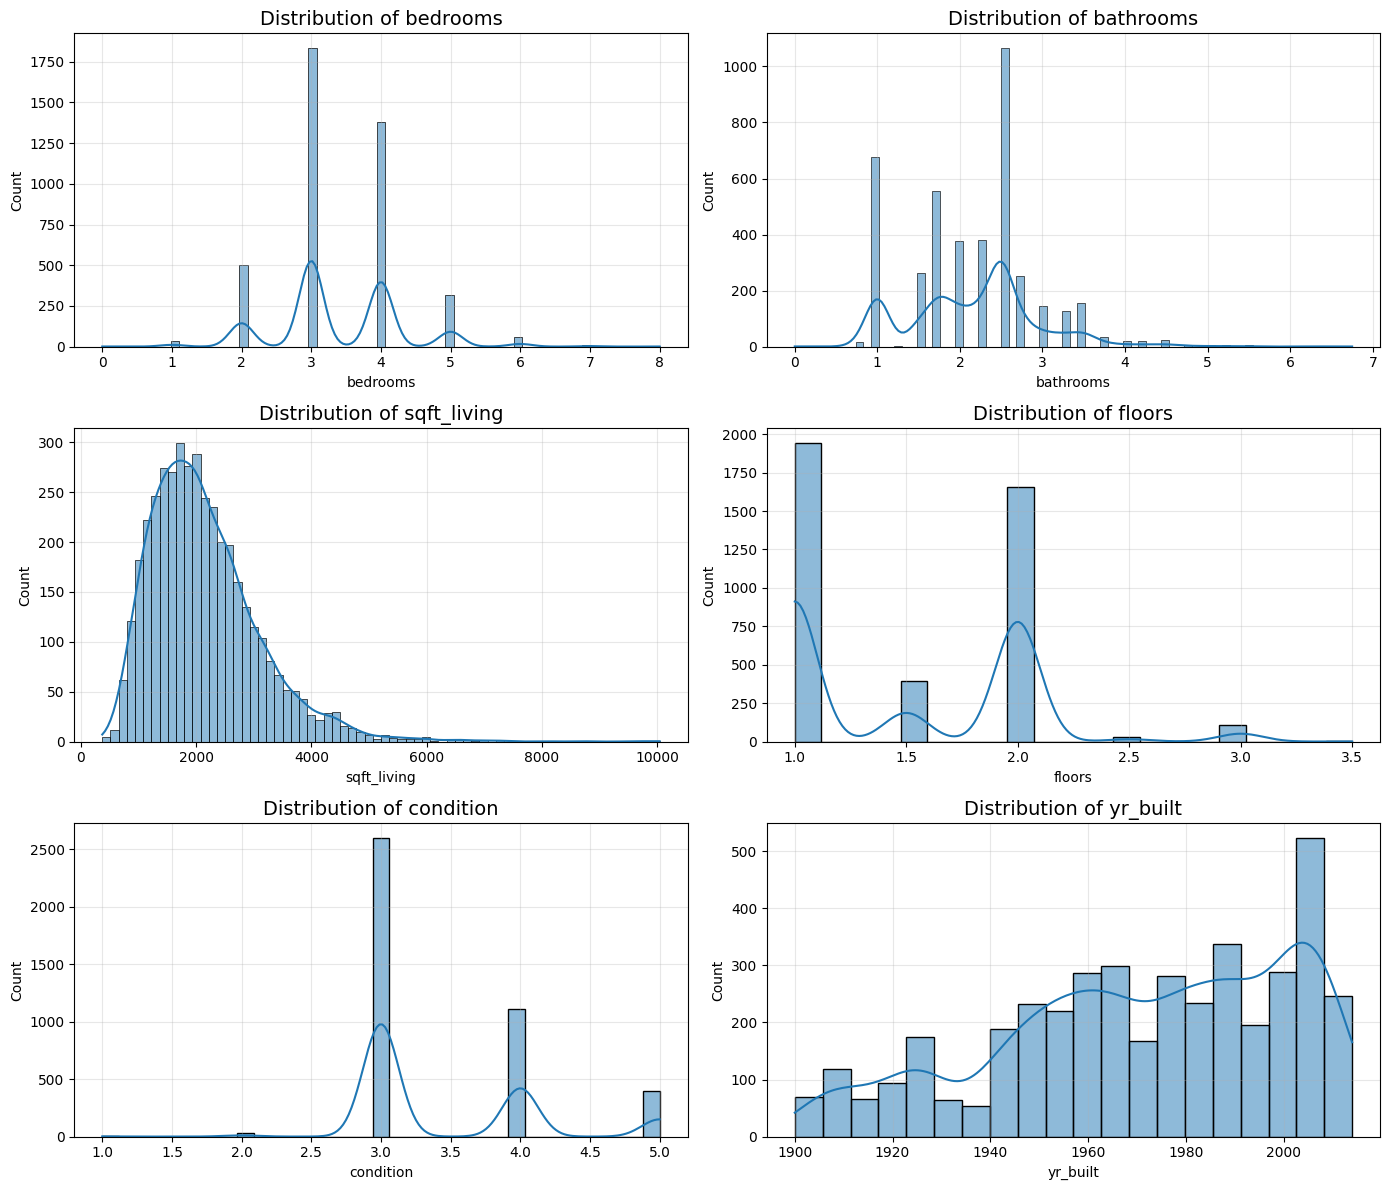

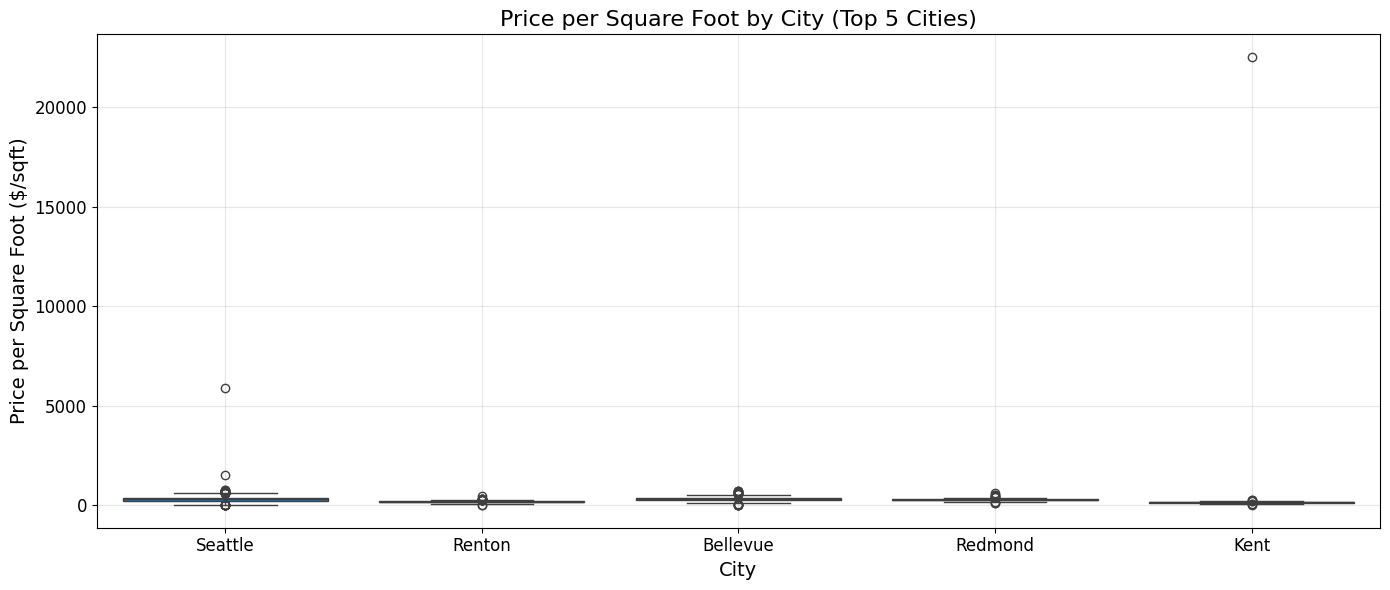

In [ ]:


# %% [markdown]
# #### 2.3.6 Feature Distribution Analysis

# %%
# Create a grid of histograms for key numerical features
key_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'condition', 'yr_built']
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# %% [markdown]

# Create a DataFrame containing city and Price_Per_SqFt data
city_price_data = df[['city', 'Price_Per_SqFt']].copy()  # Assuming 'city' and 'Price_Per_SqFt' are columns in your DataFrame 'df'

# Assuming you have determined top_5_cities based on a specific metric
top_5_cities = df['city'].value_counts().head(5).index.tolist()

# Compare price per square foot across cities
plt.figure(figsize=(14, 6))
sns.boxplot(x='city', y='Price_Per_SqFt', data=city_price_data, order=top_5_cities)
plt.title('Price per Square Foot by City (Top 5 Cities)', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Price per Square Foot ($/sqft)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




Waterfront has a positive correlation with price (0.13) and view (0.36), confirming that
waterfront properties command a premium and tend to have better views. The year built shows
moderate positive correlations with bathrooms (0.47) and floors (0.47), indicating newer
homes tend to have more bathrooms and more floors. Interestingly, yr_built has a weak
correlation with price (0.03), suggesting that age alone isn't a strong driver of price.
Year renovated shows negative correlations with most features, including a -0.32 correlation
with year built, which makes sense as older homes are more likely to be
renovated than newer ones. However, renovations don't show a strong
correlation with price (only -0.03). Surprisingly, sqft_lot has a very weak
correlation with price (0.05), suggesting that the size of the land isn't as
important as the size of the home in determining value in this market.

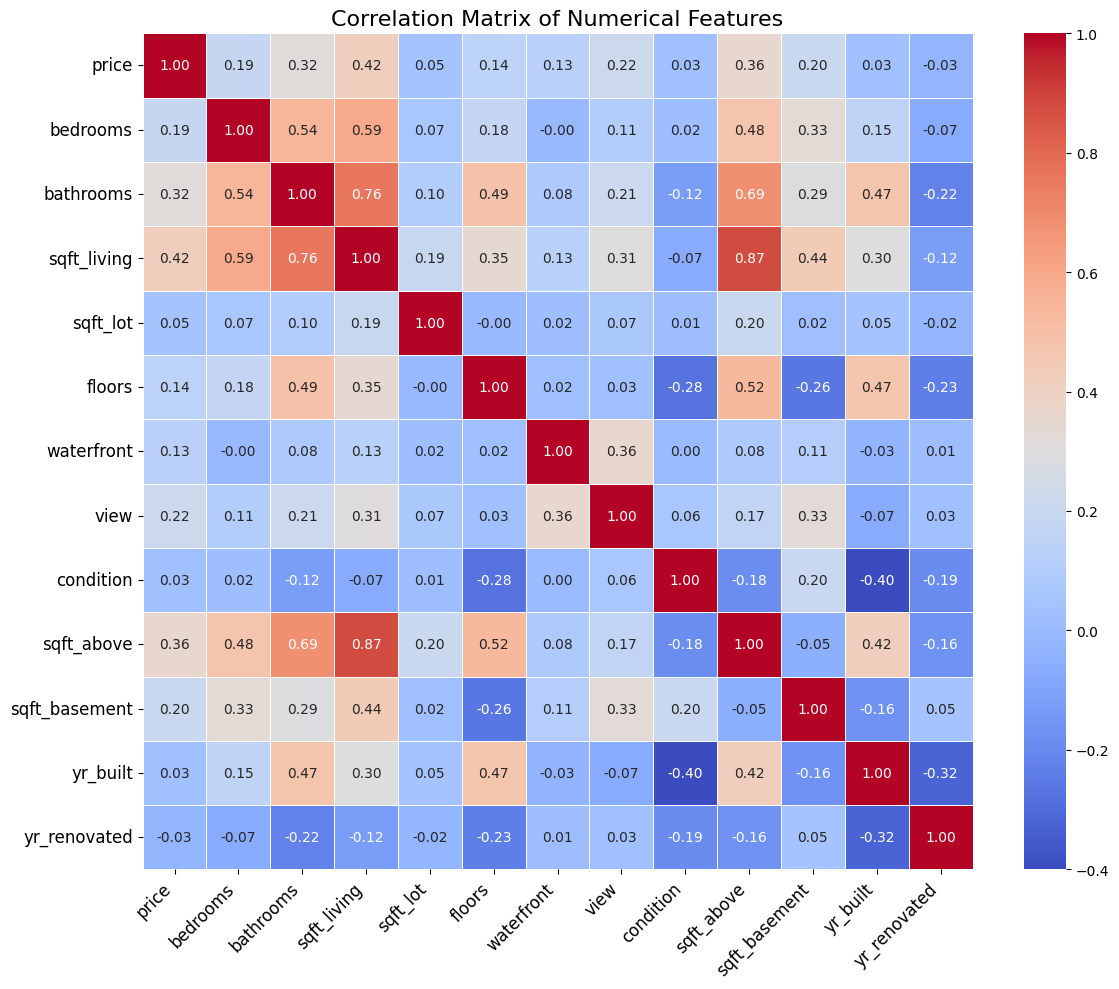

In [ ]:
# %% [markdown]
# #### 2.3.5 Correlation Analysis

# %%
# Calculate correlation matrix for numerical features
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# New Section